In [1]:
import os
import re
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())

    if len(images) < num_images:
        raise ValueError(f"Requested {num_images} images, but only {len(images)} available.")
    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    
    plt.tight_layout()
    plt.show()

def plot_training_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_results(model, dataloader, tokenizer, num_images=5):
    for images, _ in dataloader:
        images = images[:num_images].to(device)
        captions = [generate_caption(model, image, tokenizer) for image in images]

        plt.figure(figsize=(5, num_images * 5))

        for i in range(num_images):
            ax = plt.subplot(num_images, 1, i + 1)
            ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            ax.axis("off")  # Remove axes
            ax.set_title(captions[i], fontsize=12, wrap=True)

        plt.tight_layout()
        plt.show()
        break

# def display_random_images_with_captions(images_dir, captions_dict, num_images=5):
#     selected_images = random.sample(list(captions_dict.keys()), num_images)
#     plt.figure(figsize=(15, 10))

#     for i, image_id in enumerate(selected_images):
#         img_path = f"{images_dir}/{image_id}"
#         img = Image.open(img_path)

#         plt.subplot(num_images, 1, i + 1)
#         # plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(captions_dict[image_id], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()
        
def plot_caption_length_variation(captions_dict):
    lengths = []
    for captions in captions_dict.values():
        lengths.extend([len(caption.split()) for caption in captions])
    
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(lengths)), lengths, alpha=0.5)
    plt.title("Variation in Caption Lengths", fontsize=14)
    plt.xlabel("Caption Index", fontsize=12)
    plt.ylabel("Caption Length (Number of Words)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_word_frequency_histogram(captions_dict, top_n=20):
    word_counter = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            word_counter.update(preprocessed_caption.split())
    
    most_common_words = word_counter.most_common(top_n)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {top_n} Most Frequent Words", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

In [4]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

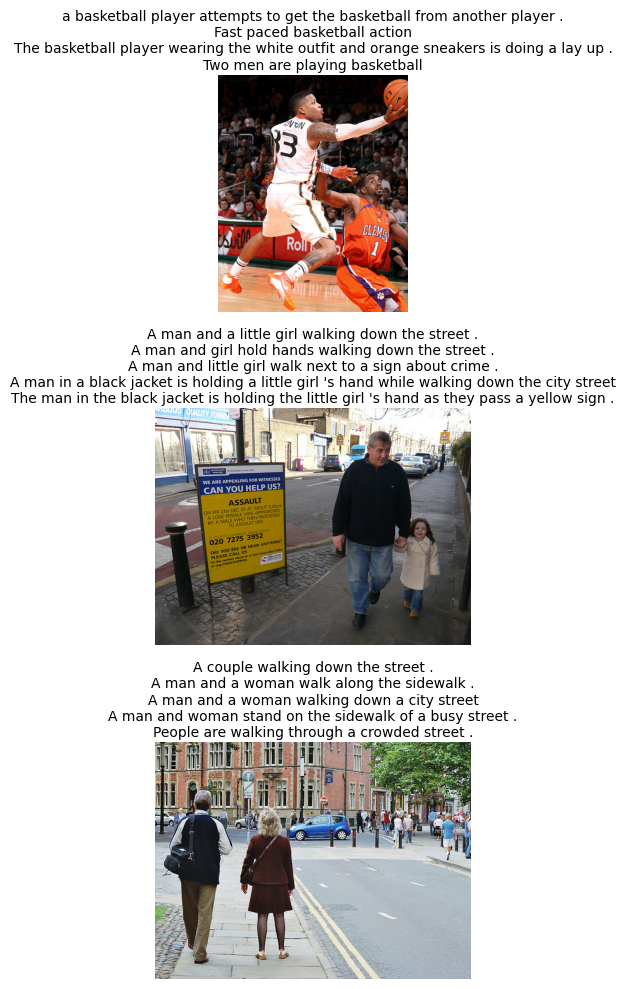

In [5]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    return text.strip()

def build_tokenizer(captions_dict):
    special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    word_to_index = defaultdict(lambda: special_tokens["<unk>"], special_tokens.copy())
    
    # Tokenize captions and build vocabulary
    vocab = set()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            vocab.update(preprocessed_caption.split())
    
    # Add vocabulary words to the tokenizer
    for idx, word in enumerate(sorted(vocab), start=len(special_tokens)):
        word_to_index[word] = idx
    
    return dict(word_to_index)

def save_tokenizer_to_json(tokenizer, filepath):
    with open(filepath, 'w') as file:
        json.dump(tokenizer, file, ensure_ascii=False, indent=4)

def caption_tokenizer(caption, word_to_index, max_length=50): # //TODO::WTF::
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    token_ids = token_ids[:max_length]
    token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    return torch.tensor(token_ids)

In [7]:
word_to_index_tokenizer = build_tokenizer(captions_dict)

TOKENIZER_FILE = "tokenizer.json"
save_tokenizer_to_json(word_to_index_tokenizer, TOKENIZER_FILE)

print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_tokenizer)}")

Word to Index Tokenizer saved to tokenizer.json. Total tokens: 8478


In [8]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [9]:
# display_random_images_with_captions(IMAGES_DIR, captions_dict, num_images=5)

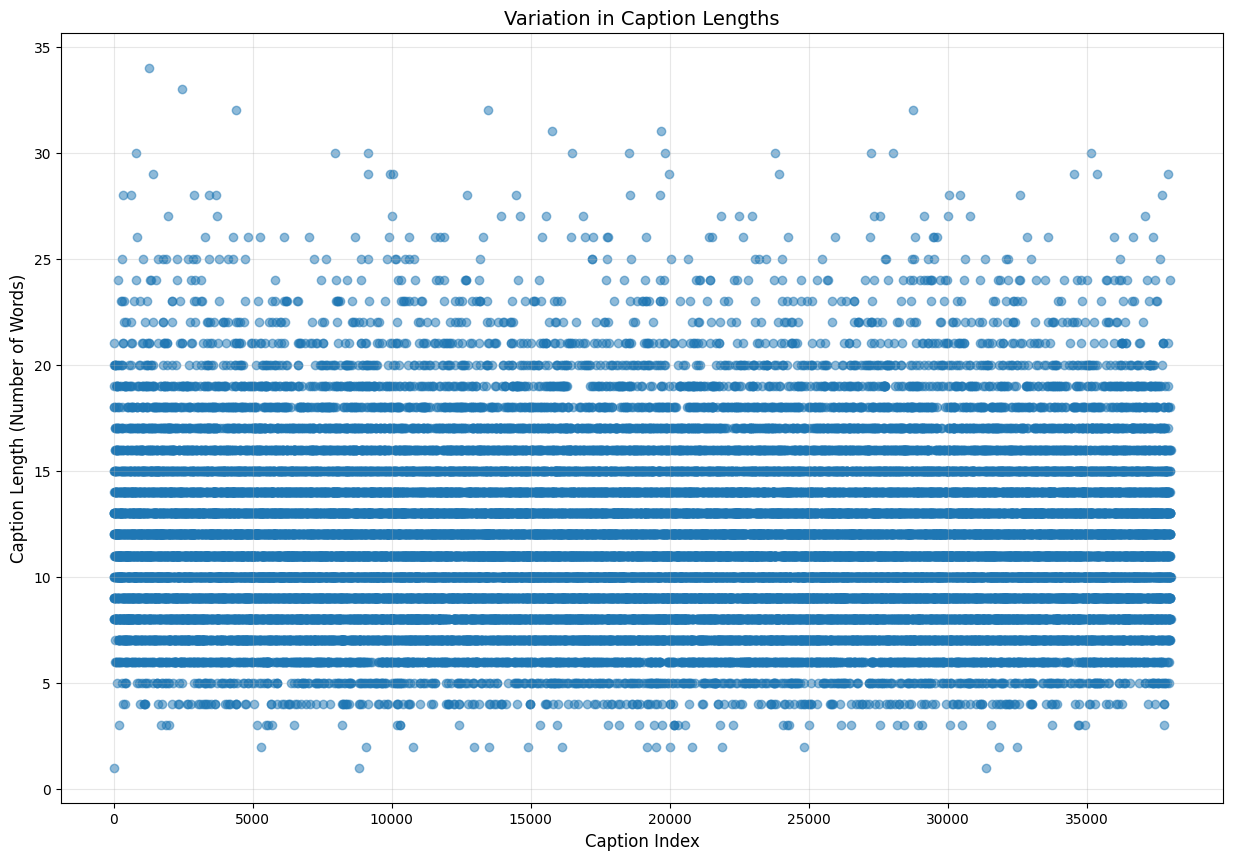

In [10]:
plot_caption_length_variation(captions_dict)

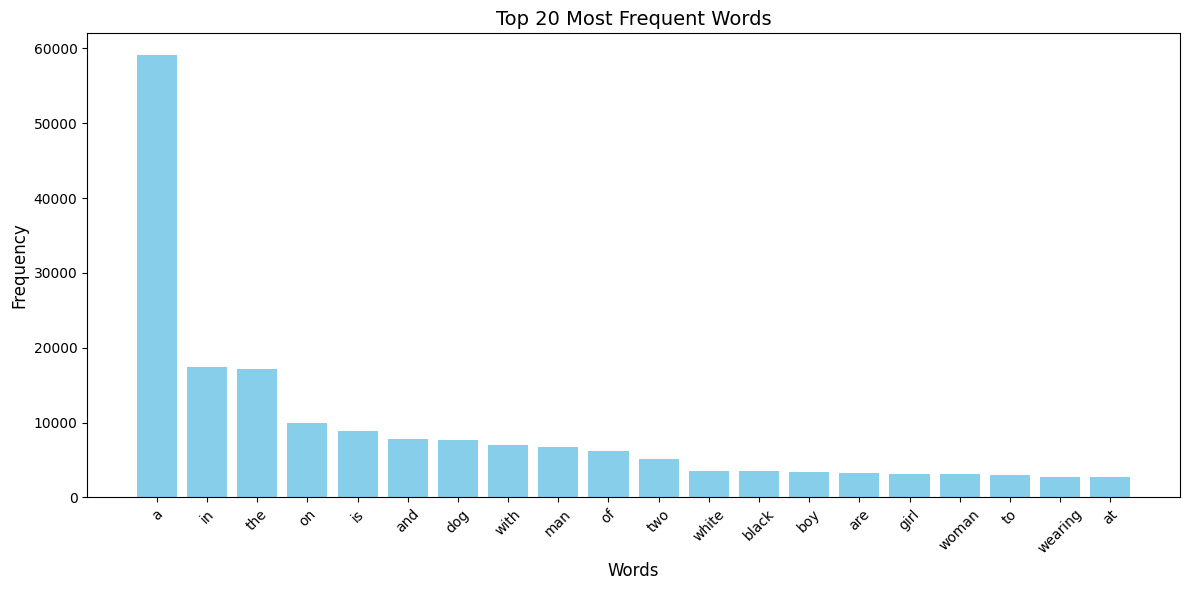

In [11]:
plot_word_frequency_histogram(captions_dict, top_n=20)

In [12]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)

        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if os.path.exists(image_path):
                for caption in captions:
                    self.image_caption_pairs.append((image_id, caption))
        
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            caption = self.tokenizer(caption)

        return image, caption

def create_dataloaders(images_dir, train_captions_file, val_captions_file, test_captions_file, batch_size, tokenizer):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = FlickrDataset(train_captions_file, images_dir, transform=transform_train, tokenizer=tokenizer)
    val_dataset = FlickrDataset(val_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    test_dataset = FlickrDataset(test_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [13]:
with open(TOKENIZER_FILE, "r") as file:
    word_to_index = json.load(file)

train_loader, val_loader, test_loader = create_dataloaders(
    IMAGES_DIR,
    "train_captions.json",
    "val_captions.json",
    "test_captions.json",
    BATCH_SIZE,
    lambda caption: caption_tokenizer(caption, word_to_index)
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 476
Validation batches: 60
Testing batches: 60


In [14]:
PAD_IDX = word_to_index_tokenizer["<pad>"]

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=256):
        super(EncoderCNN, self).__init__()
        self.efficient_net = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        # Global Average Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        # Linear layer to project features to desired size
        self.fc = nn.Linear(1280, encoded_image_size)

    def forward(self, images):
        features = self.efficient_net.features(images)  # Extract convolutional features
        pooled_features = self.pool(features).squeeze(-1).squeeze(-1)  # Global average pooling
        projected_features = self.fc(pooled_features)  # Reduce dimensionality
        return projected_features  # Final feature vector for the decoder

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Word embedding layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)  # Final prediction layer
        self.dropout = nn.Dropout(dropout)
        # Linear layer to project encoder output to LSTM hidden size
        self.encoder_to_hidden = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        batch_size = features.size(0)
        # Project encoder output to LSTM hidden state size
        h0 = self.encoder_to_hidden(features).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros_like(h0).to(features.device)  # Initialize cell state with zeros
        # Embed the input captions
        embeddings = self.dropout(self.embed(captions))  # (batch_size, seq_len, embed_size)
        # Concatenate features as the first input to the LSTM
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)  # (batch_size, seq_len + 1, embed_size)
        # Pass through LSTM
        hiddens, _ = self.lstm(inputs, (h0, c0))  # (batch_size, seq_len + 1, hidden_size)
        # Compute word predictions
        outputs = self.fc(hiddens)  # (batch_size, seq_len + 1, vocab_size)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)  # Extract image features
        outputs = self.decoder(features, captions)  # Generate captions
        return outputs


def masked_cross_entropy_loss(outputs, targets):
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    return loss_fn(outputs.permute(0, 2, 1), targets)  # Permute for [batch_size, vocab_size, seq_len]

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path="checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer): # //TODO::WTF:: I don't know how to use till no.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, loss

def generate_caption(model, image, tokenizer, max_length=20):
    model.eval() 

    index_to_word = {index: word for word, index in tokenizer.items()}
    start_token = tokenizer["<sos>"]
    end_token = tokenizer["<eos>"]

    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))

        caption = [start_token]  # Begin with <sos>
        for _ in range(max_length):
            caption_tensor = torch.tensor([caption], device=device)  # Shape: (1, current_seq_len)
            outputs = model.decoder(features, caption_tensor)
            next_word_idx = outputs[0, -1].argmax().item()
            caption.append(next_word_idx)
            if next_word_idx == end_token:
                break

    words = [index_to_word[idx] for idx in caption if idx != start_token and idx != end_token]
    return " ".join(words)

In [16]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, 
    checkpoint_path="checkpoint.pth", resume=False, patience=5,
    weight_decay=1e-4
):
    model.train()
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience-2)

    if resume and os.path.exists(checkpoint_path):
        start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    else:
        start_epoch = 0
        
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0 

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (images, captions) in enumerate(tepoch):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()

            outputs = model(images, captions[:, :-1])  # Exclude the last word for teacher forcing            
            outputs = outputs[:, :captions.size(1) - 1, :]  # Match target sequence length

            loss = masked_cross_entropy_loss(outputs, captions[:, 1:])  # Exclude <sos> for target TODO::WTF:: what about the first character? it should be excluded too.
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            tepoch.set_postfix(loss=f"{loss.item():.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = masked_cross_entropy_loss(outputs, captions[:, 1:])
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)
        # print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
            save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

In [17]:
vocab_size = len(word_to_index_tokenizer)  # Tokenizer vocabulary size
embed_size = 512       # Size of image feature vector and word embeddings
hidden_size = 512      # Size of the LSTM hidden state
num_layers = 1         # Number of layers in LSTM
dropout = 0.5          # Dropout rate
learning_rate = 0.001  # Initial learning rate
weight_decay = 1e-4    # Weight decay for regularization

encoder = EncoderCNN(encoded_image_size=embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, dropout=dropout).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [18]:
# print(model)

In [19]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=75, 
    checkpoint_path="caption_model.pth", patience=15
)

Epoch 1, Train Loss: 4.4216


Epoch 1, Validation Loss: 4.1192


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                                                                          

Epoch 2, Train Loss: 4.0095


Epoch 2, Validation Loss: 3.9831


Epoch 3, Train Loss: 3.8833


Epoch 3, Validation Loss: 3.9228


Epoch 4, Train Loss: 3.8021


Epoch 4, Validation Loss: 3.8811


Epoch 5, Train Loss: 3.7439


Epoch 5, Validation Loss: 3.9021
No improvement in validation loss for 1 epoch(s).


Epoch 6, Train Loss: 3.7030


Epoch 6, Validation Loss: 3.8395


Epoch 7, Train Loss: 3.6678


Epoch 7, Validation Loss: 3.8047


Epoch 8, Train Loss: 3.6364


Epoch 8, Validation Loss: 3.8659
No improvement in validation loss for 1 epoch(s).


Epoch 9, Train Loss: 3.6092


Epoch 9, Validation Loss: 3.8058
No improvement in validation loss for 2 epoch(s).


Epoch 10, Train Loss: 3.5857


Epoch 10, Validation Loss: 3.8063
No improvement in validation loss for 3 epoch(s).


Epoch 11, Train Loss: 3.5612


Epoch 11, Validation Loss: 3.7986


Epoch 12, Train Loss: 3.5393


Epoch 12, Validation Loss: 3.8014
No improvement in validation loss for 1 epoch(s).


Epoch 13, Train Loss: 3.5259


Epoch 13, Validation Loss: 3.7945


Epoch 14, Train Loss: 3.5098


Epoch 14, Validation Loss: 3.7834


Epoch 15, Train Loss: 3.4963


Epoch 15, Validation Loss: 3.7548


Epoch 16, Train Loss: 3.4835


Epoch 16, Validation Loss: 3.7681
No improvement in validation loss for 1 epoch(s).


Epoch 17, Train Loss: 3.4690


Epoch 17, Validation Loss: 3.7807
No improvement in validation loss for 2 epoch(s).


Epoch 18, Train Loss: 3.4552


Epoch 18, Validation Loss: 3.7890
No improvement in validation loss for 3 epoch(s).


Epoch 19, Train Loss: 3.4489


Epoch 19, Validation Loss: 3.7526


Epoch 20, Train Loss: 3.4390


Epoch 20, Validation Loss: 3.7467


Epoch 21, Train Loss: 3.4295


Epoch 21, Validation Loss: 3.7864
No improvement in validation loss for 1 epoch(s).


Epoch 22, Train Loss: 3.4197


Epoch 22, Validation Loss: 3.7609
No improvement in validation loss for 2 epoch(s).


Epoch 23, Train Loss: 3.4139


Epoch 23, Validation Loss: 3.8357
No improvement in validation loss for 3 epoch(s).


Epoch 24, Train Loss: 3.4066


Epoch 24, Validation Loss: 3.7716
No improvement in validation loss for 4 epoch(s).


Epoch 25, Train Loss: 3.4022


Epoch 25, Validation Loss: 3.7574
No improvement in validation loss for 5 epoch(s).


Epoch 26, Train Loss: 3.3960


Epoch 26, Validation Loss: 3.7427


Epoch 27, Train Loss: 3.3864


Epoch 27, Validation Loss: 3.7622
No improvement in validation loss for 1 epoch(s).


Epoch 28, Train Loss: 3.3807


Epoch 28, Validation Loss: 3.8248
No improvement in validation loss for 2 epoch(s).


Epoch 29, Train Loss: 3.3761


Epoch 29, Validation Loss: 3.7898
No improvement in validation loss for 3 epoch(s).


Epoch 30, Train Loss: 3.3698


Epoch 30, Validation Loss: 3.7597
No improvement in validation loss for 4 epoch(s).


Epoch 31, Train Loss: 3.3667


Epoch 31, Validation Loss: 3.7572
No improvement in validation loss for 5 epoch(s).


Epoch 32, Train Loss: 3.3607


Epoch 32, Validation Loss: 3.7661
No improvement in validation loss for 6 epoch(s).


Epoch 33, Train Loss: 3.3571


Epoch 33, Validation Loss: 3.7365


Epoch 34, Train Loss: 3.3488


Epoch 34, Validation Loss: 3.7652
No improvement in validation loss for 1 epoch(s).


Epoch 35, Train Loss: 3.3479


Epoch 35, Validation Loss: 3.7817
No improvement in validation loss for 2 epoch(s).


Epoch 36, Train Loss: 3.3428


Epoch 36, Validation Loss: 3.7714
No improvement in validation loss for 3 epoch(s).


Epoch 37, Train Loss: 3.3390


Epoch 37, Validation Loss: 3.7331


Epoch 38, Train Loss: 3.3364


Epoch 38, Validation Loss: 3.7814
No improvement in validation loss for 1 epoch(s).


Epoch 39, Train Loss: 3.3300


Epoch 39, Validation Loss: 3.7854
No improvement in validation loss for 2 epoch(s).


Epoch 40, Train Loss: 3.3261


Epoch 40, Validation Loss: 3.7472
No improvement in validation loss for 3 epoch(s).


Epoch 41, Train Loss: 3.3219


Epoch 41, Validation Loss: 3.8065
No improvement in validation loss for 4 epoch(s).


Epoch 42, Train Loss: 3.3208


Epoch 42, Validation Loss: 3.7897
No improvement in validation loss for 5 epoch(s).


Epoch 43, Train Loss: 3.3162


Epoch 43, Validation Loss: 3.7585
No improvement in validation loss for 6 epoch(s).


Epoch 44, Train Loss: 3.3123


Epoch 44, Validation Loss: 3.7534
No improvement in validation loss for 7 epoch(s).


Epoch 45, Train Loss: 3.3084


Epoch 45, Validation Loss: 3.7679
No improvement in validation loss for 8 epoch(s).


Epoch 46, Train Loss: 3.3067


Epoch 46, Validation Loss: 3.7746
No improvement in validation loss for 9 epoch(s).


Epoch 47, Train Loss: 3.3027


Epoch 47, Validation Loss: 3.7983
No improvement in validation loss for 10 epoch(s).


Epoch 48, Train Loss: 3.2978


Epoch 48, Validation Loss: 3.7762
No improvement in validation loss for 11 epoch(s).


Epoch 49, Train Loss: 3.2974


Epoch 49, Validation Loss: 3.8171
No improvement in validation loss for 12 epoch(s).


Epoch 50, Train Loss: 3.2942


Epoch 50, Validation Loss: 3.7411
No improvement in validation loss for 13 epoch(s).


Epoch 51, Train Loss: 3.2933


Epoch 51, Validation Loss: 3.7154


Epoch 52, Train Loss: 3.2881


Epoch 52, Validation Loss: 3.7823
No improvement in validation loss for 1 epoch(s).


Epoch 53, Train Loss: 3.2839


Epoch 53, Validation Loss: 3.7498
No improvement in validation loss for 2 epoch(s).


Epoch 54, Train Loss: 3.2817


Epoch 54, Validation Loss: 3.7542
No improvement in validation loss for 3 epoch(s).


Epoch 55, Train Loss: 3.2812


Epoch 55, Validation Loss: 3.7591
No improvement in validation loss for 4 epoch(s).


Epoch 56, Train Loss: 3.2787


Epoch 56, Validation Loss: 3.7664
No improvement in validation loss for 5 epoch(s).


Epoch 57, Train Loss: 3.2732


Epoch 57, Validation Loss: 3.7820
No improvement in validation loss for 6 epoch(s).


Epoch 58, Train Loss: 3.2732


Epoch 58, Validation Loss: 3.7742
No improvement in validation loss for 7 epoch(s).


Epoch 59, Train Loss: 3.2714


Epoch 59, Validation Loss: 3.7835
No improvement in validation loss for 8 epoch(s).


Epoch 60, Train Loss: 3.2674


Epoch 60, Validation Loss: 3.8157
No improvement in validation loss for 9 epoch(s).


Epoch 61, Train Loss: 3.2674


Epoch 61, Validation Loss: 3.7674
No improvement in validation loss for 10 epoch(s).


Epoch 62, Train Loss: 3.2629


Epoch 62, Validation Loss: 3.8253
No improvement in validation loss for 11 epoch(s).


Epoch 63, Train Loss: 3.2600


Epoch 63, Validation Loss: 3.7659
No improvement in validation loss for 12 epoch(s).


Epoch 64, Train Loss: 3.2601


Epoch 64, Validation Loss: 3.7598
No improvement in validation loss for 13 epoch(s).


Epoch 65, Train Loss: 3.2572


Epoch 65, Validation Loss: 3.8080
No improvement in validation loss for 14 epoch(s).


Epoch 66, Train Loss: 3.2528


Epoch 66, Validation Loss: 3.8171
No improvement in validation loss for 15 epoch(s).
Early stopping triggered.


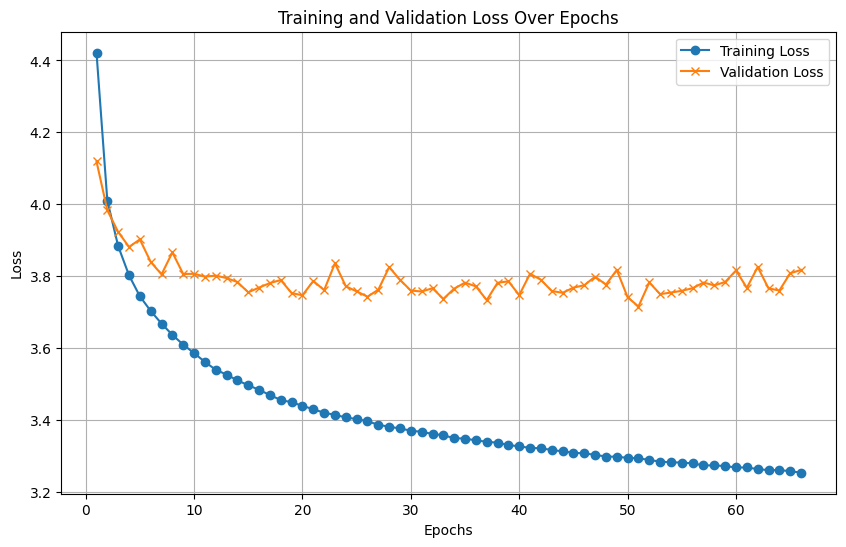

In [20]:
plot_training_losses(train_losses, val_losses)

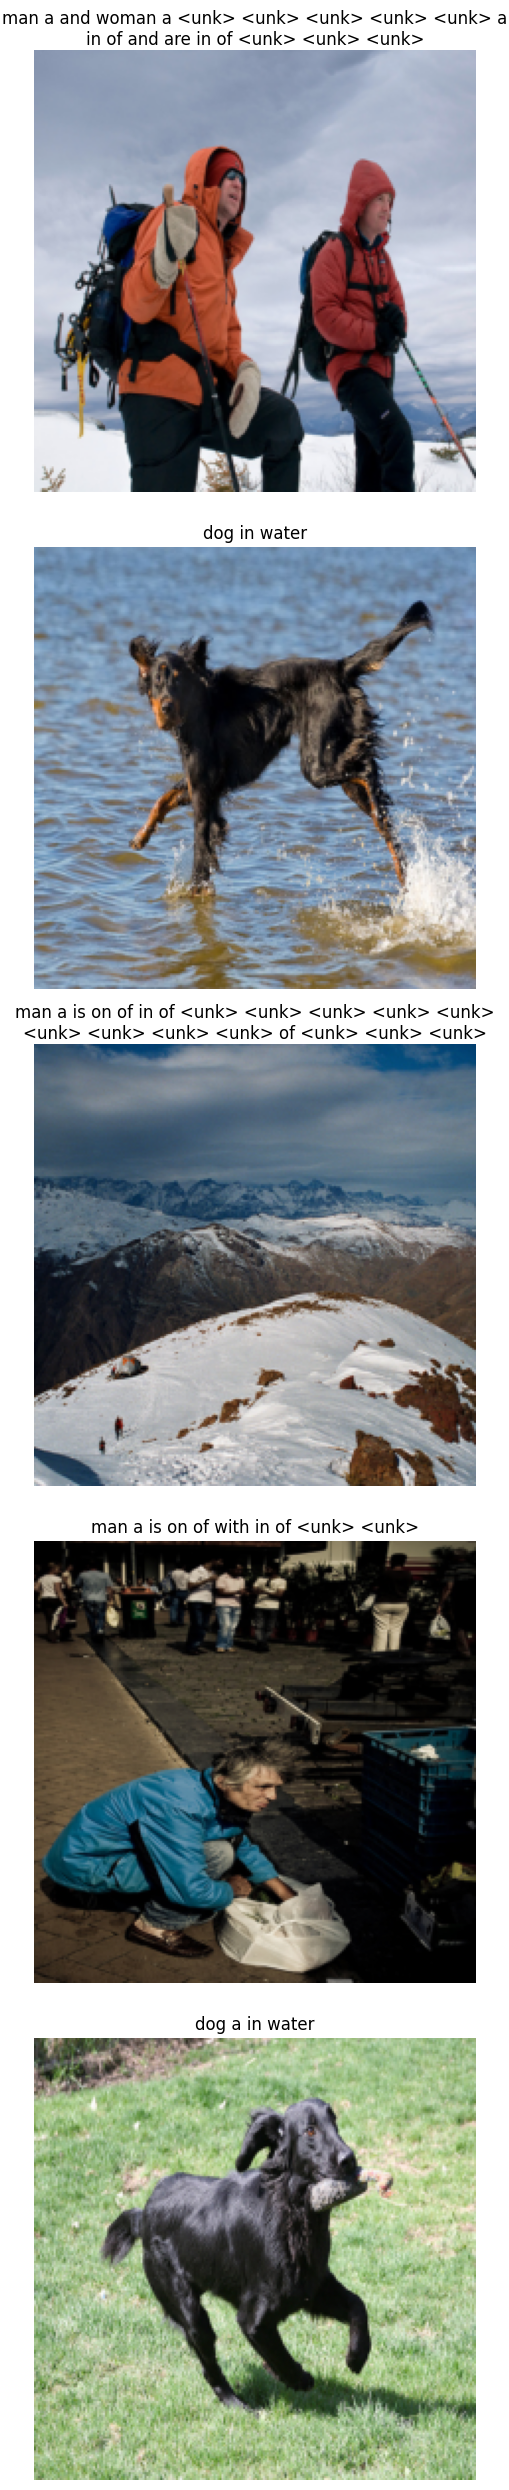

In [21]:
visualize_results(model, test_loader, word_to_index_tokenizer)